In [ ]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15508, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 15508 (delta 66), reused 177 (delta 39), pack-reused 15275
Receiving objects: 100% (15508/15508), 6.39 MiB | 17.82 MiB/s, done.
Resolving deltas: 100% (11177/11177), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

detectron2 version: 0.6


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

# Register train, valid, and test sets with different names
for d in ["train", "valid", "test"]:
    dataset_name = f"bone_fractures_{d}"
    if dataset_name not in detectron2.data.DatasetCatalog:
        register_coco_instances(
            dataset_name,
            {},
            f"/content/drive/MyDrive/bone/coco train/_annotations.coco.json",
            f"/content/drive/MyDrive/bone/coco train/train"
        )
    else:
        print(f"Dataset '{dataset_name}' is already registered!")



In [ ]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[03/18 17:17:33 d2.data.datasets.coco]: Loading /content/drive/MyDrive/bone/coco train/_annotations.coco.json takes 1.06 seconds.
WARNING [03/18 17:17:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/18 17:17:33 d2.data.datasets.coco]: Loaded 1846 images in COCO format from /content/drive/MyDrive/bone/coco train/_annotations.coco.json


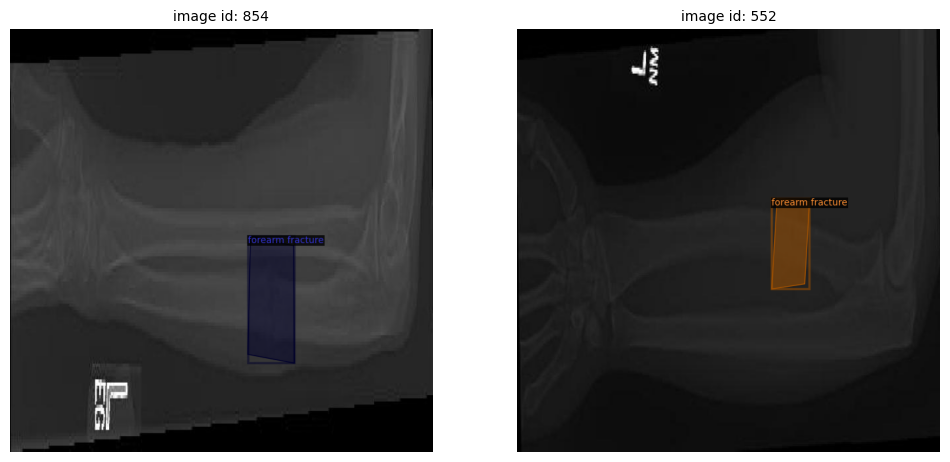

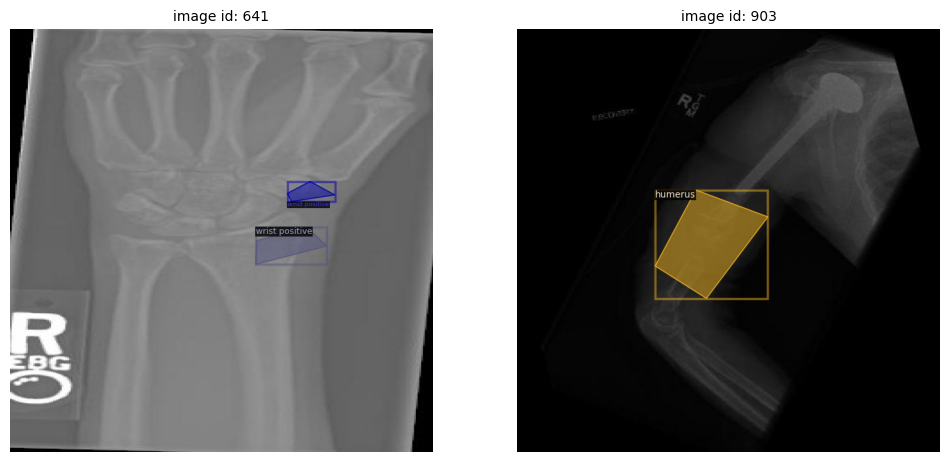

In [ ]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 34 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 56 , image_scale = 1)

# <span style="color:#e74c3c;">Training a Faster R-CNN model with a ResNeXt-101 backbone and Feature Pyramid Network (FPN)


In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 2000
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/18 17:17:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:02, 165MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/18 17:17:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/18 17:18:20 d2.utils.events]:  eta: 0:34:10  iter: 19  total_loss: 2.403  loss_cls: 2.215  loss_box_reg: 0.01478  loss_rpn_cls: 0.1901  loss_rpn_loc: 0.01273    time: 1.0288  last_time: 0.9065  data_time: 0.0518  last_data_time: 0.0051   lr: 1.9981e-05  max_mem: 3896M
[03/18 17:18:45 d2.utils.events]:  eta: 0:34:40  iter: 39  total_loss: 1.442  loss_cls: 1.277  loss_box_reg: 0.01494  loss_rpn_cls: 0.2127  loss_rpn_loc: 0.015    time: 1.0468  last_time: 1.2342  data_time: 0.0065  last_data_time: 0.0063   lr: 3.9961e-05  max_mem: 3896M
[03/18 17:19:06 d2.utils.events]:  eta: 0:34:42  iter: 59  total_loss: 0.4446  loss_cls: 0.2325  loss_box_reg: 0.03279  loss_rpn_cls: 0.117  loss_rpn_loc: 0.01139    time: 1.0626  last_time: 1.1349  data_time: 0.0084  last_data_time: 0.0121   lr: 5.9941e-05  max_mem: 3896M
[03/18 17:19:29 d2.utils.events]:  eta: 0:34:45  iter: 79  total_loss: 0.266  loss_cls: 0.0819  loss_box_reg: 0.02432  loss_rpn_cls: 0.161  loss_rpn_loc: 0.0129    time: 1.0767  last

In [ ]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[03/18 17:57:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Training Results

In [ ]:

def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/content/output/metrics.json')

total_loss1 = metric(train_metrics, 'total_loss')
cls_acc1 = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg1 = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg1 = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss1))

Text(0.5, 1.0, 'False Negative')

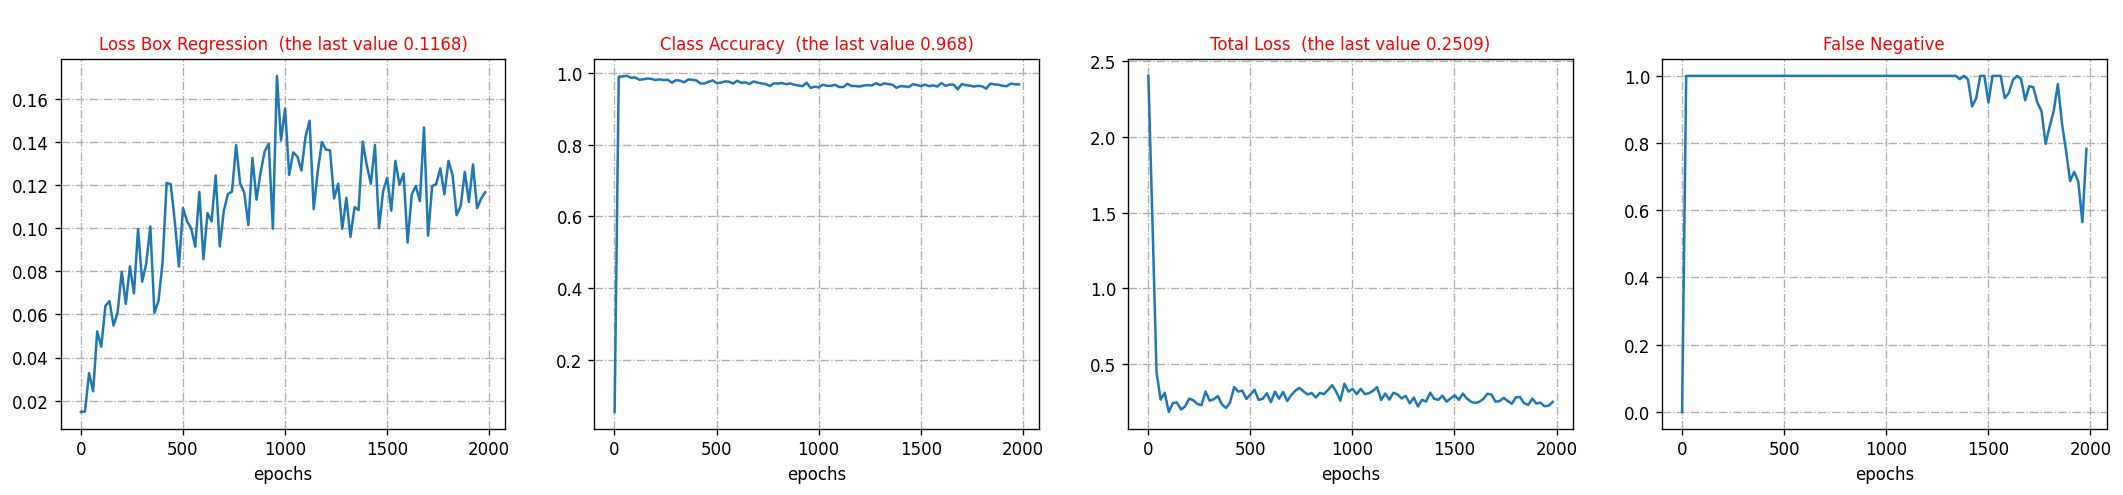

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (22, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")
fig.suptitle('                                                                   ', color = 'blue', fontsize=15,  style = "italic")


axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg1)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg1[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc1)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc1[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss1)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss1[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg1)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[03/18 18:00:19 d2.evaluation.evaluator]: Inference done 11/1846. Dataloading: 0.0041 s/iter. Inference: 0.1837 s/iter. Eval: 0.0004 s/iter. Total: 0.1883 s/iter. ETA=0:05:45
[03/18 18:00:24 d2.evaluation.evaluator]: Inference done 38/1846. Dataloading: 0.0028 s/iter. Inference: 0.1843 s/iter. Eval: 0.0003 s/iter. Total: 0.1876 s/iter. ETA=0:05:39
[03/18 18:00:29 d2.evaluation.evaluator]: Inference done 65/1846. Dataloading: 0.0023 s/iter. Inference: 0.1850 s/iter. Eval: 0.0003 s/iter. Total: 0.1878 s/iter. ETA=0:05:34
[03/18 18:00:34 d2.evaluation.evaluator]: Inference done 91/1846. Dataloading: 0.0035 s/iter. Inference: 0.1858 s/iter. Eval: 0.0003 s/iter. Total: 0.1898 s/iter. ETA=0:05:33
[03/18 18:00:39 d2.evaluation.evaluator]: Inference done 117/1846. Dataloading: 0.0034 s/iter. Inference: 0.1866 s/iter. Eval: 0.0003 s/iter. Total: 0.1905 s/iter. ETA=0:05:29
[03/18 18:00:44 d2.evaluation.evaluator]: Inference done 143/1846. Dataloading: 0.0037 s/iter. Inference: 0.1873 s/iter. Eva

OrderedDict([('bbox',
              {'AP': 12.559269815790858,
               'AP50': 37.345244695251075,
               'AP75': 4.404442104665205,
               'APs': 2.721706876032959,
               'APm': 14.61338287882081,
               'APl': 12.528463824078159,
               'AP-dectection': nan,
               'AP-elbow positive': 14.469097350868147,
               'AP-fingers positive': 12.028547827322084,
               'AP-forearm fracture': 18.939972688422475,
               'AP-humerus': 22.403171735217644,
               'AP-humerus fracture': 0.0,
               'AP-shoulder fracture': 14.644913586161652,
               'AP-wrist positive': 5.429185522543987})])

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (6,9), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original box (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted box (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [03/18 18:06:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/18 18:06:15 d2.data.datasets.coco]: Loaded 1846 images in COCO format from /content/drive/MyDrive/bone/coco train/_annotations.coco.json


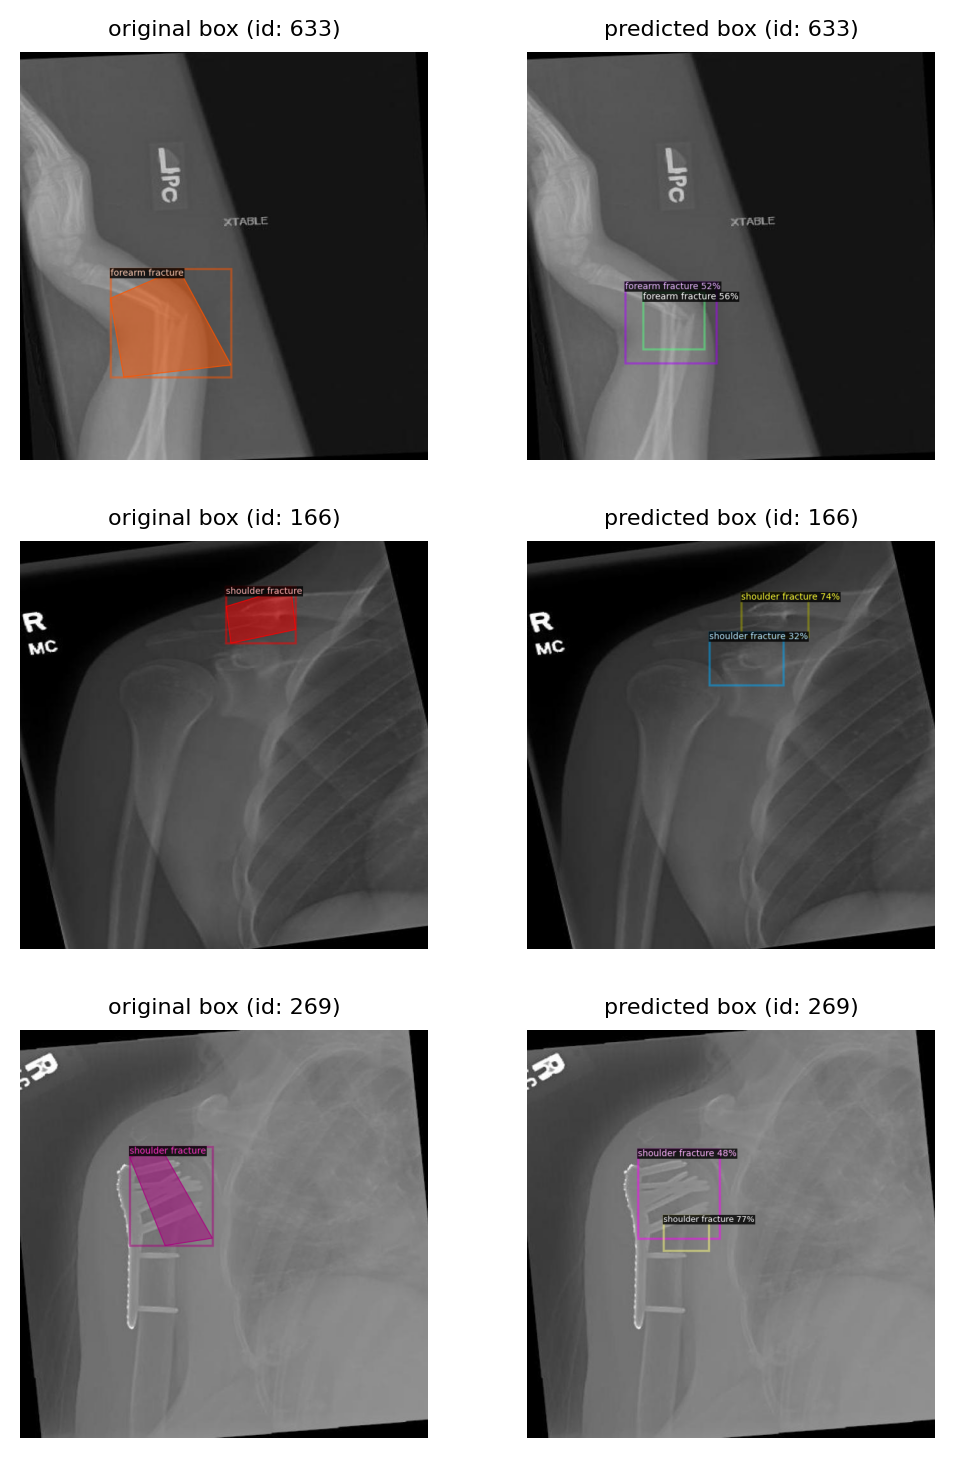

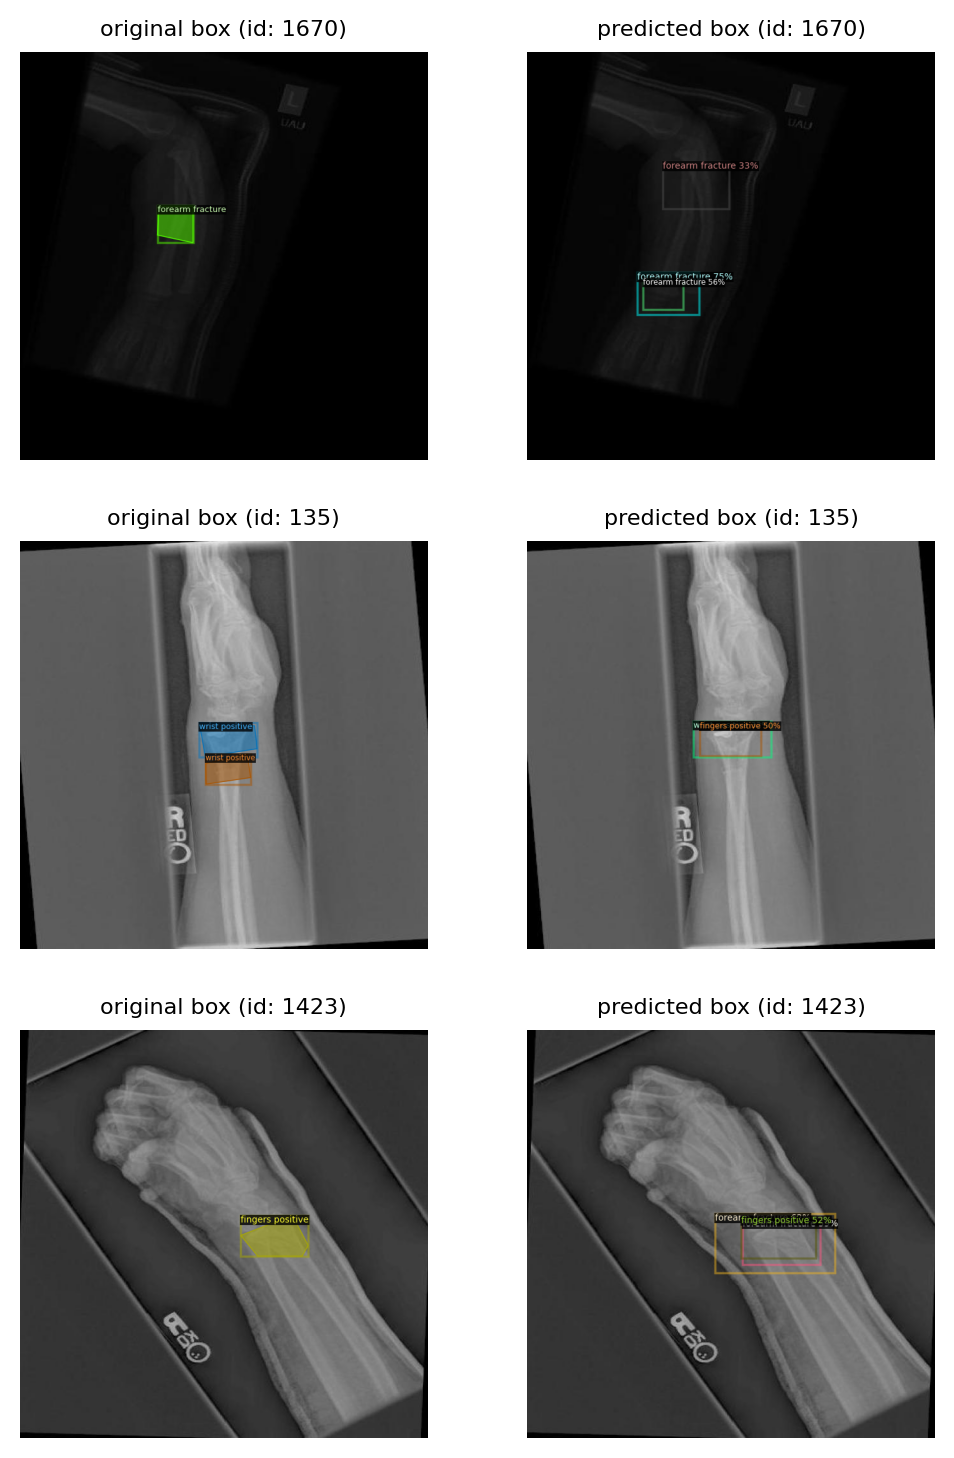

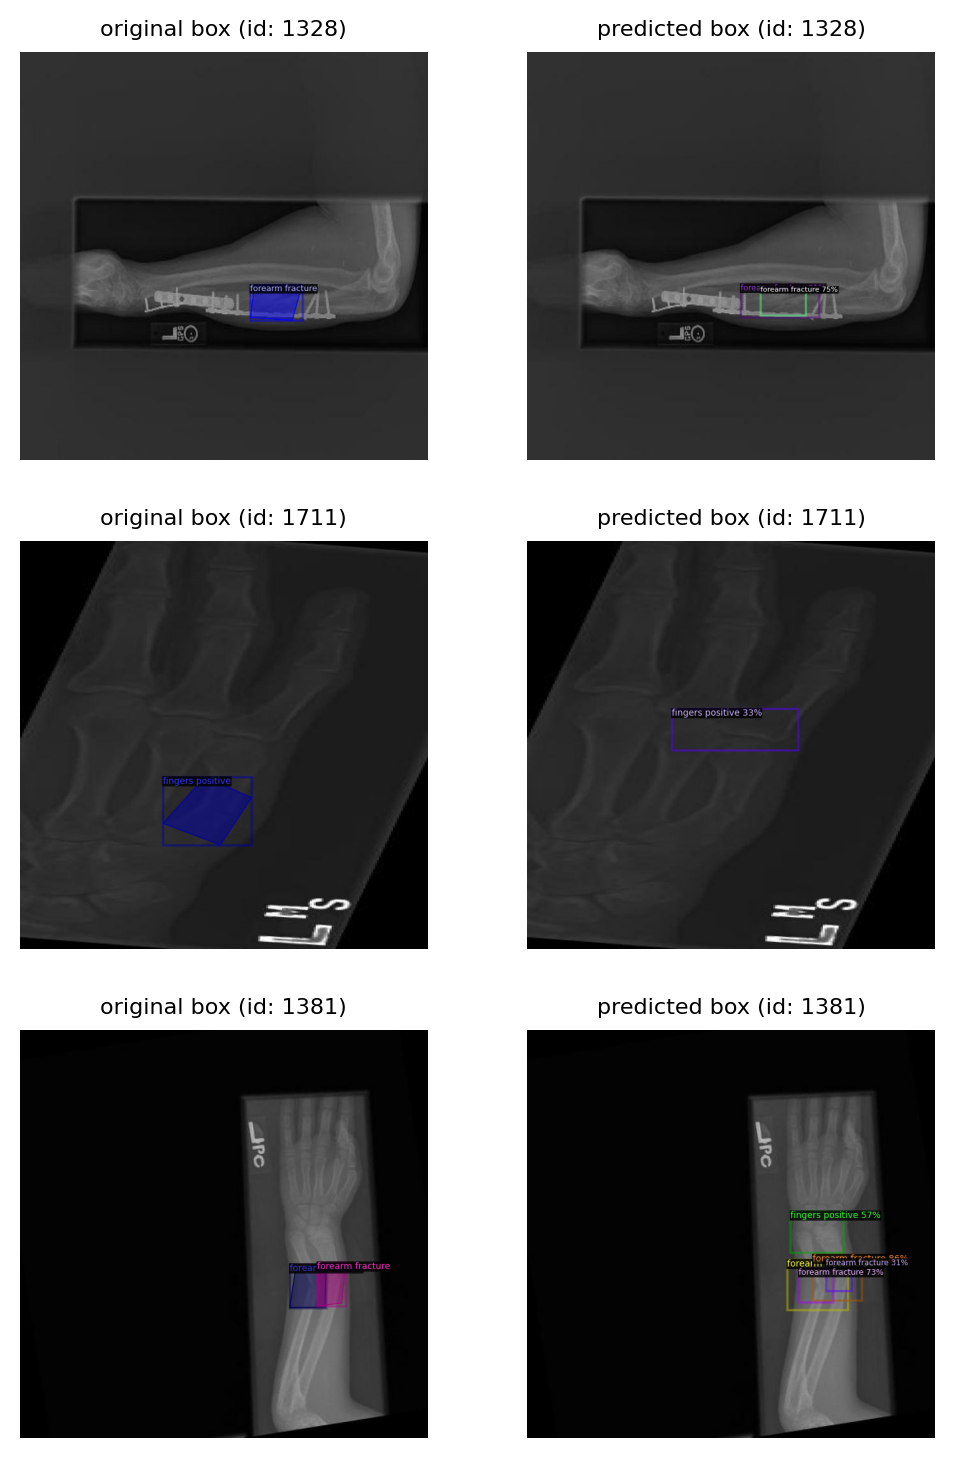

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 228, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 643, image_scale=1)

# <span style="color:#e74c3c;">Training a Faster R-CNN model with a ResNeXt-50 backbone and Feature Pyramid Network (FPN)



In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 2000
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/18 18:32:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/18 18:32:24 d2.engine.train_loop]: Starting training from iteration 0
[03/18 18:32:31 d2.utils.events]:  eta: 0:11:26  iter: 19  total_loss: 2.202  loss_cls: 2.065  loss_box_reg: 0.02503  loss_rpn_cls: 0.1313  loss_rpn_loc: 0.01046    time: 0.3455  last_time: 0.3493  data_time: 0.0206  last_data_time: 0.0069   lr: 1.9981e-05  max_mem: 3898M
[03/18 18:32:38 d2.utils.events]:  eta: 0:10:57  iter: 39  total_loss: 1.405  loss_cls: 1.188  loss_box_reg: 0.005183  loss_rpn_cls: 0.1438  loss_rpn_loc: 0.01042    time: 0.3379  last_time: 0.3377  data_time: 0.0063  last_data_time: 0.0070   lr: 3.9961e-05  max_mem: 3898M
[03/18 18:32:45 d2.utils.events]:  eta: 0:10:45  iter: 59  total_loss: 0.41  loss_cls: 0.2697  loss_box_reg: 0.0233  loss_rpn_cls: 0.117  loss_rpn_loc: 0.01414    time: 0.3376  last_time: 0.3564  data_time: 0.0080  last_data_time: 0.0062   lr: 5.9941e-05  max_mem: 3898M
[03/18 18:32:52 d2.utils.events]:  eta: 0:10:38  iter: 79  total_loss: 0.2656  loss_cls: 0.1007  loss_box_re

In [ ]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[03/18 18:44:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Training result

In [ ]:

def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/content/output/metrics.json')

total_loss2 = metric(train_metrics, 'total_loss')
cls_acc2 = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg2 = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg2 = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss2))

Text(0.5, 1.0, 'False Negative')

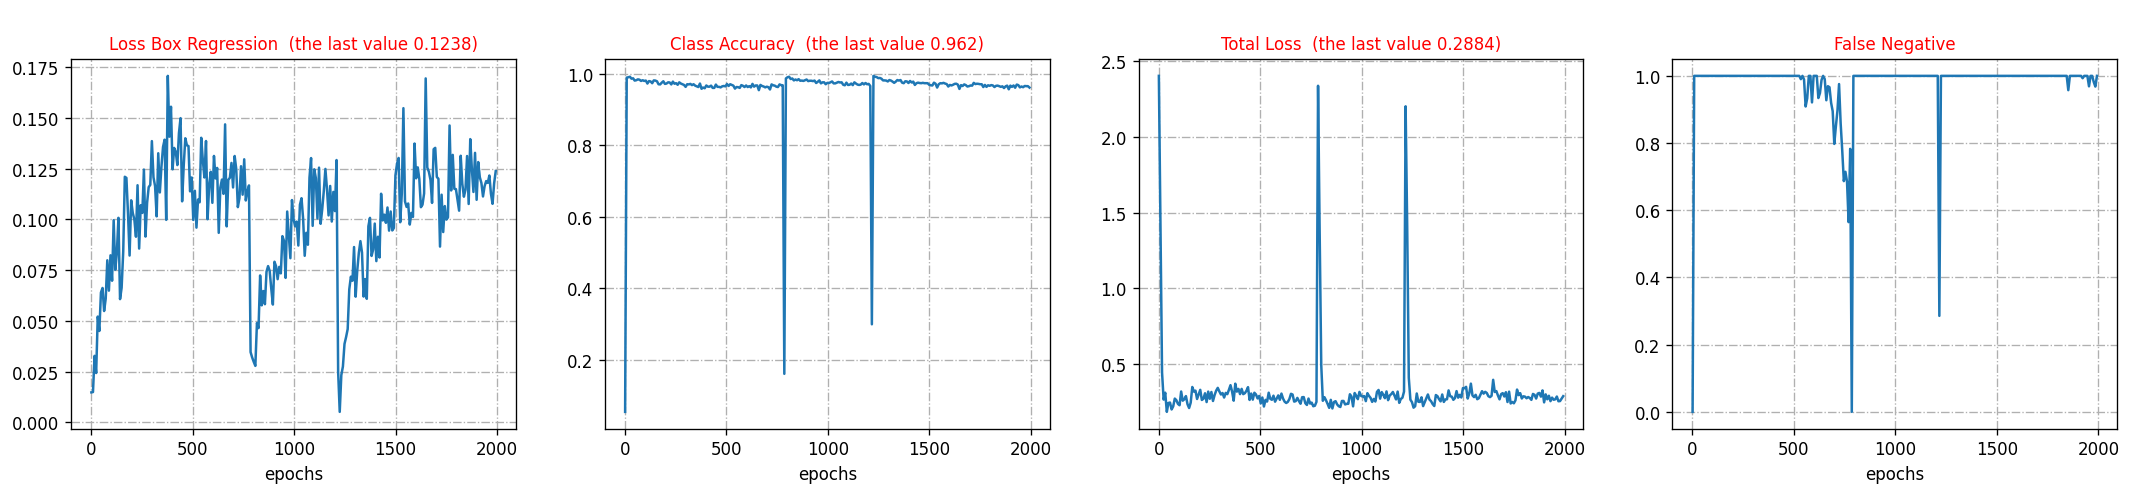

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (22, 4), dpi = 120)

fig.suptitle('Faster R-CNN w/ResNet-50 FPN Training Results', color = 'blue', fontsize=15,  style = "italic")
fig.suptitle('                                                                   ', color = 'blue', fontsize=15,  style = "italic")


axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg2)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg2[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc2)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc2[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss2)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss2[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg2)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[03/18 18:44:05 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/18 18:44:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/18 18:44:05 d2.data.datasets.coco]: Loaded 1846 images in COCO format from /content/drive/MyDrive/bone/coco train/_annotations.coco.json
[03/18 18:44:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/18 18:44:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/18 18:44:05 d2.data.common]: Serializing 1846 elements to byte tensors and concatenating them all ...
[03/18 18:44:05 d2.data.common]: Serialized dataset takes 0.79 MiB
[03/18 18:44:05 d2.evaluation.evaluator]: Start inference on 1846 batches
[03/18 18:44:07 d2.evaluation.evaluator]: Inference done 11/1846

OrderedDict([('bbox',
              {'AP': 6.105683392349891,
               'AP50': 19.9961332481449,
               'AP75': 1.3352336216284897,
               'APs': 1.6045934229249392,
               'APm': 5.55218627380169,
               'APl': 8.048201063239357,
               'AP-dectection': nan,
               'AP-elbow positive': 4.382464889428776,
               'AP-fingers positive': 4.197829705517581,
               'AP-forearm fracture': 10.2797929033856,
               'AP-humerus': 14.538298434559238,
               'AP-humerus fracture': 0.0,
               'AP-shoulder fracture': 5.059742986575142,
               'AP-wrist positive': 4.281654826982898})])

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (7,10), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original box (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted box (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [03/18 18:46:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/18 18:46:48 d2.data.datasets.coco]: Loaded 1846 images in COCO format from /content/drive/MyDrive/bone/coco train/_annotations.coco.json


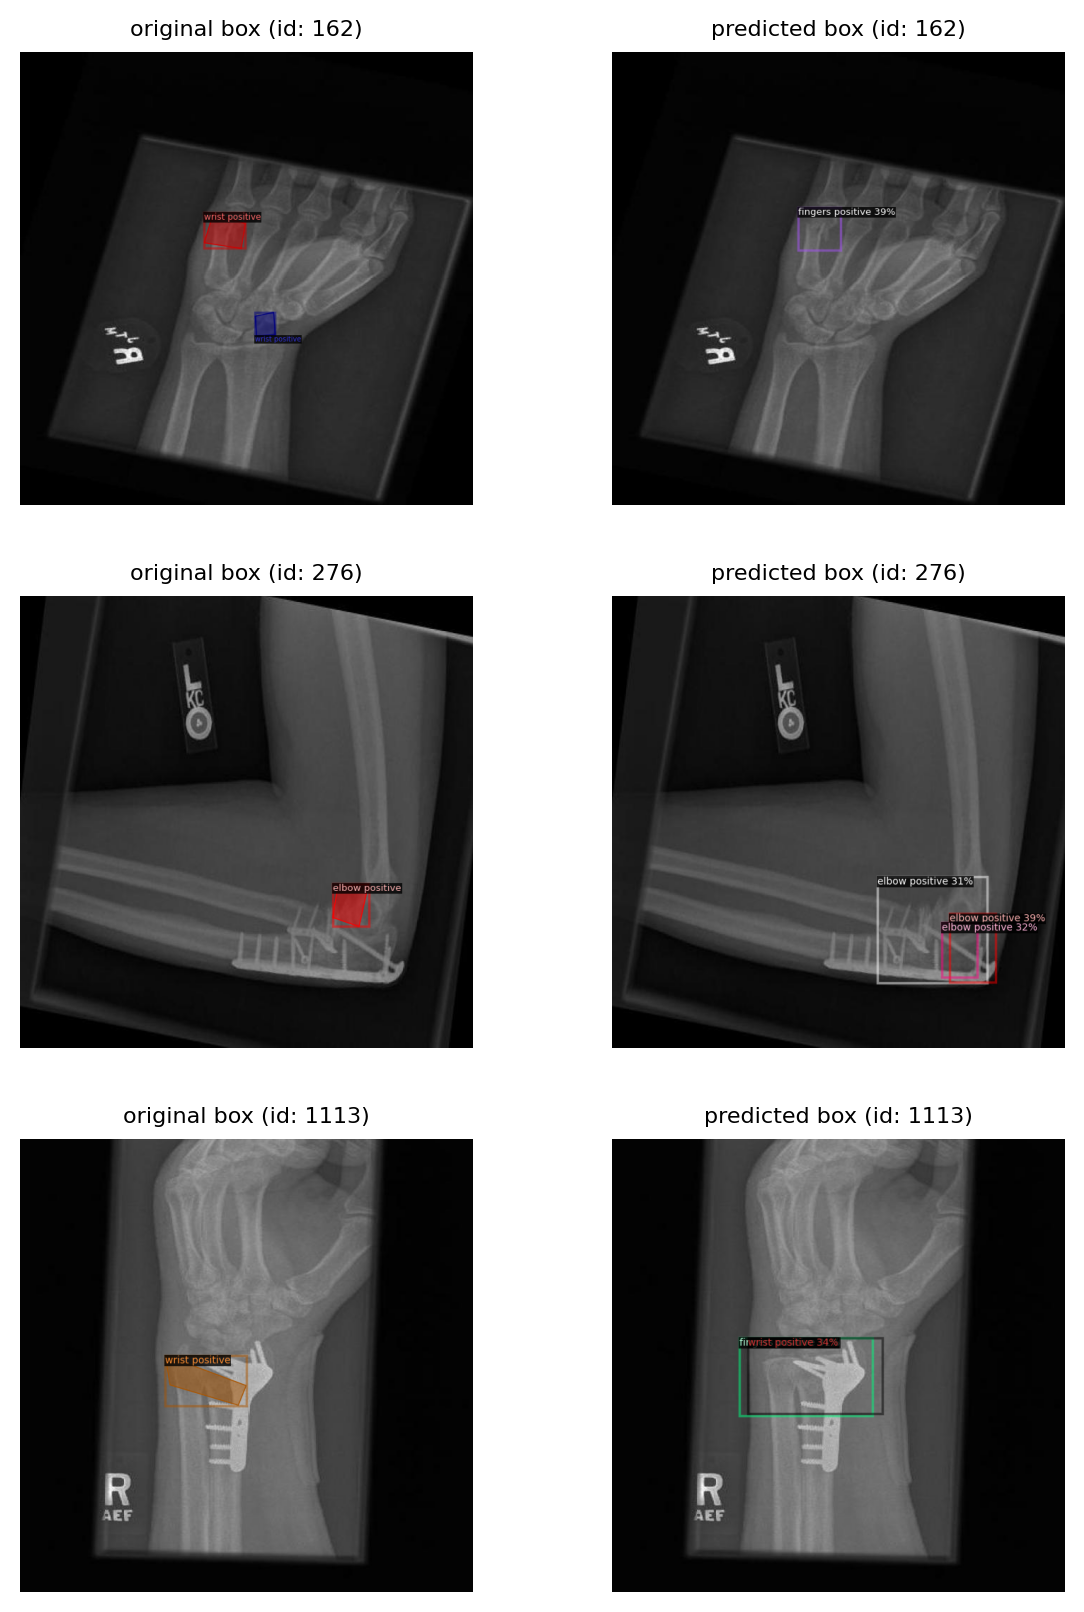

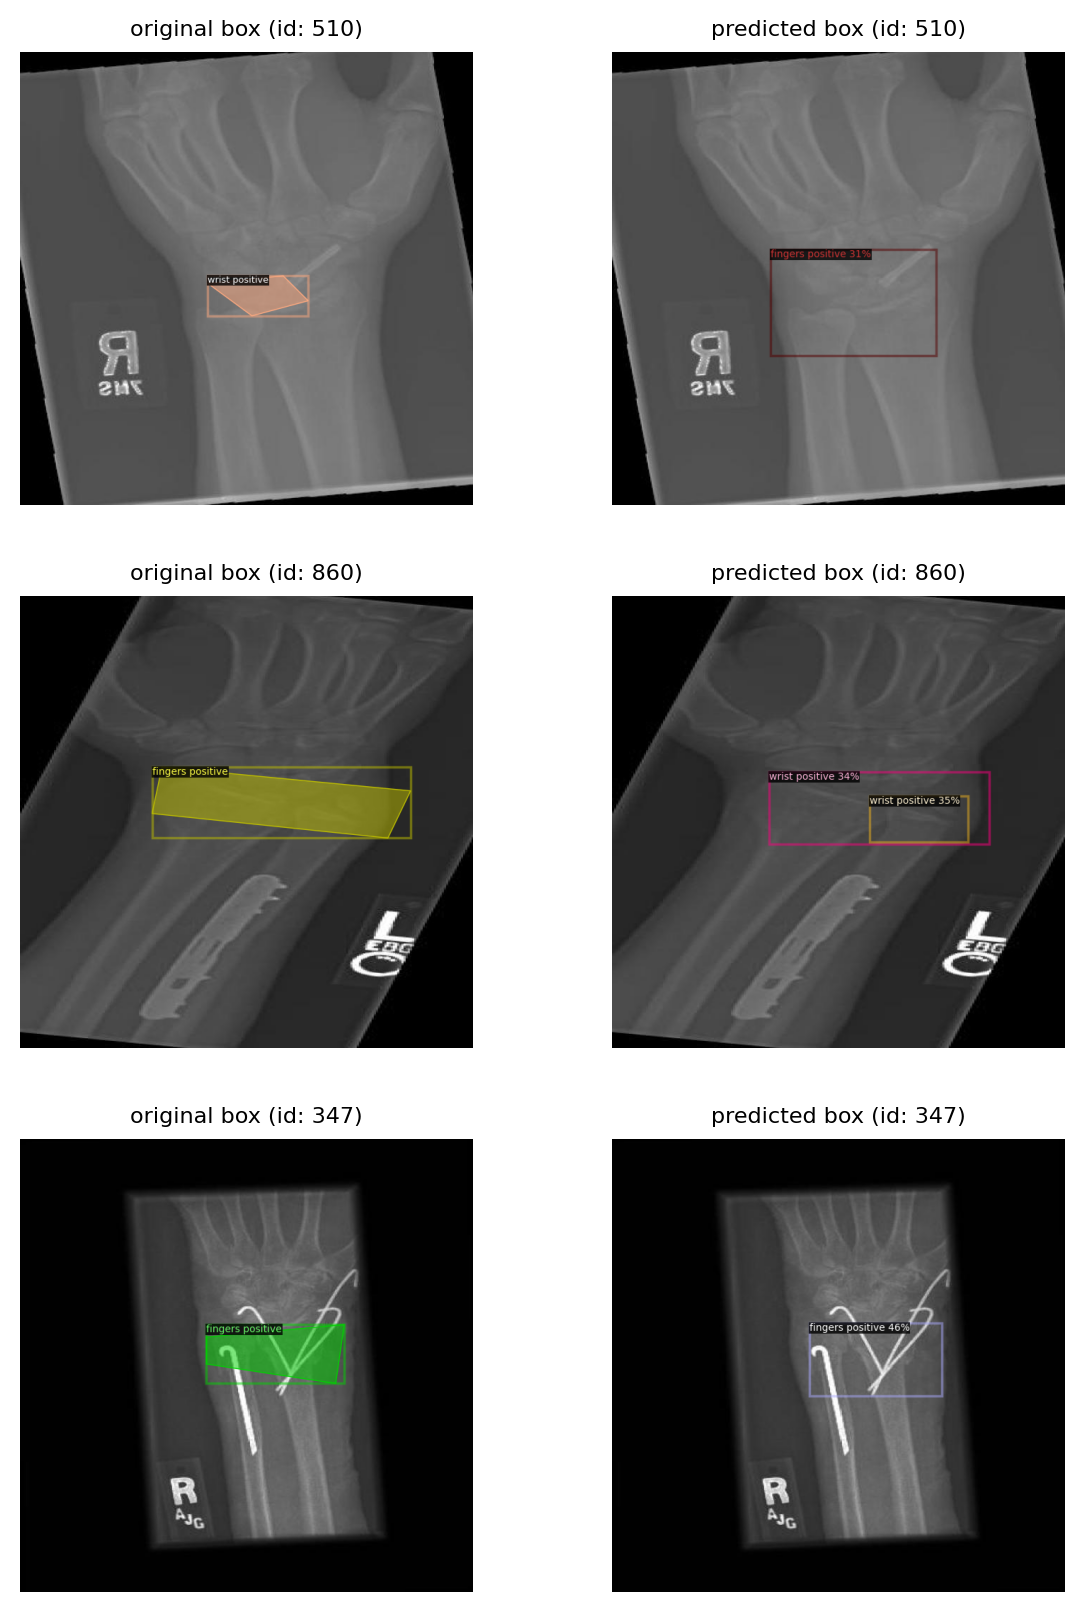

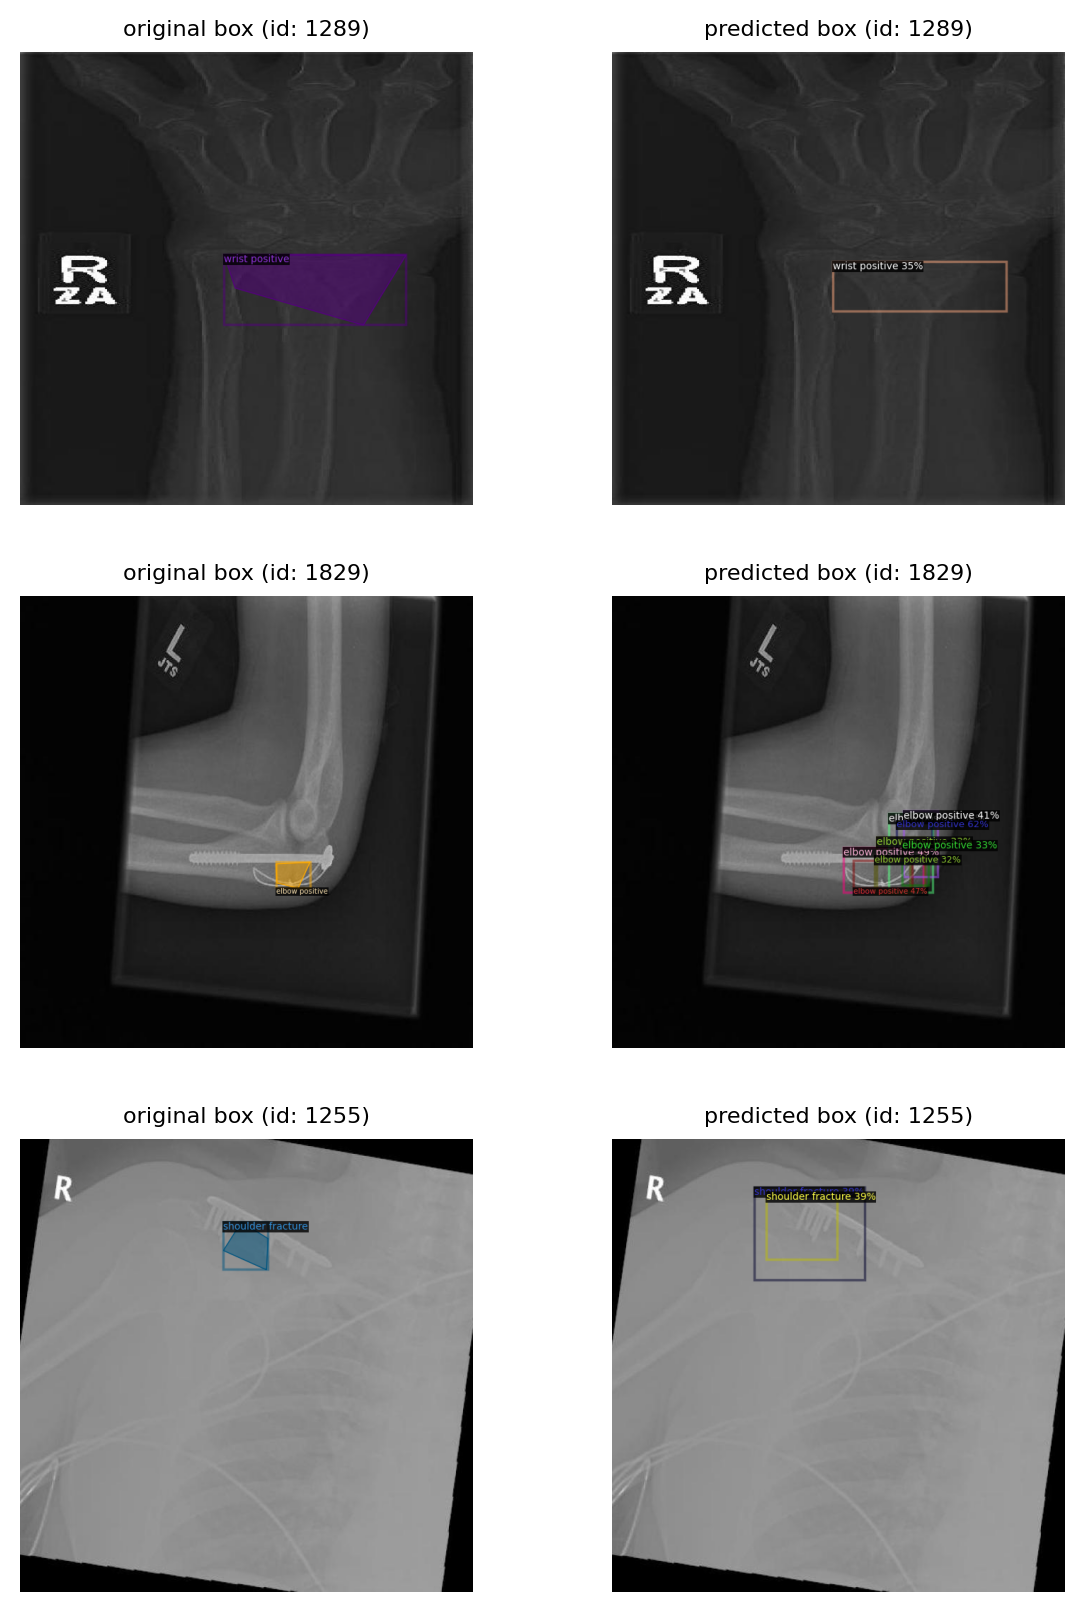

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 4, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 83, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 743, image_scale=1)

In [ ]:
# Print the final values of each metric for both models
print("Final Metrics for Model 1:")
print("Total Loss:", total_loss1[-1])
print("Classification Accuracy:", cls_acc1[-1])
print("False Negatives:", false_neg1[-1])
print("Loss Box Regression:", loss_box_reg1[-1])

print("\nFinal Metrics for Model 2:")
print("Total Loss:", total_loss2[-1])
print("Classification Accuracy:", cls_acc2[-1])
print("False Negatives:", false_neg2[-1])
print("Loss Box Regression:", loss_box_reg2[-1])


Final Metrics for Model 1:
Total Loss: 0.25085820793174207
Classification Accuracy: 0.96826171875
False Negatives: 0.7827731092436975
Loss Box Regression: 0.11675924435257912

Final Metrics for Model 2:
Total Loss: 0.28843019739724696
Classification Accuracy: 0.9619140625
False Negatives: 1.0
Loss Box Regression: 0.12381748110055923


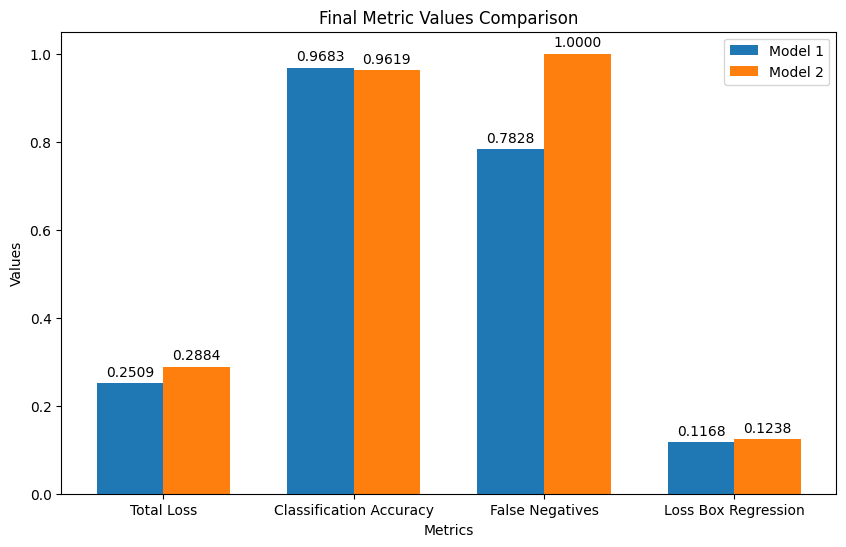

In [ ]:
import matplotlib.pyplot as plt

# Define metric names and values for both models
metrics = ['Total Loss', 'Classification Accuracy', 'False Negatives', 'Loss Box Regression']
model1_values = [total_loss1[-1], cls_acc1[-1], false_neg1[-1], loss_box_reg1[-1]]
model2_values = [total_loss2[-1], cls_acc2[-1], false_neg2[-1], loss_box_reg2[-1]]

# Function to format values to display only the first four digits
def format_values(values):
    return ["{:.4f}".format(value) for value in values]

model1_values_formatted = format_values(model1_values)
model2_values_formatted = format_values(model2_values)

# Plotting
fig, axs = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))

bar1 = axs.bar(index, model1_values, bar_width, label='Model 1')
bar2 = axs.bar([i + bar_width for i in index], model2_values, bar_width, label='Model 2')

# Function to add labels on top of bars
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        axs.annotate('{}'.format(value),
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1, model1_values_formatted)
add_labels(bar2, model2_values_formatted)

axs.set_xlabel('Metrics')
axs.set_ylabel('Values')
axs.set_title('Final Metric Values Comparison')
axs.set_xticks([i + bar_width / 2 for i in index])
axs.set_xticklabels(metrics)
axs.legend()

plt.show()


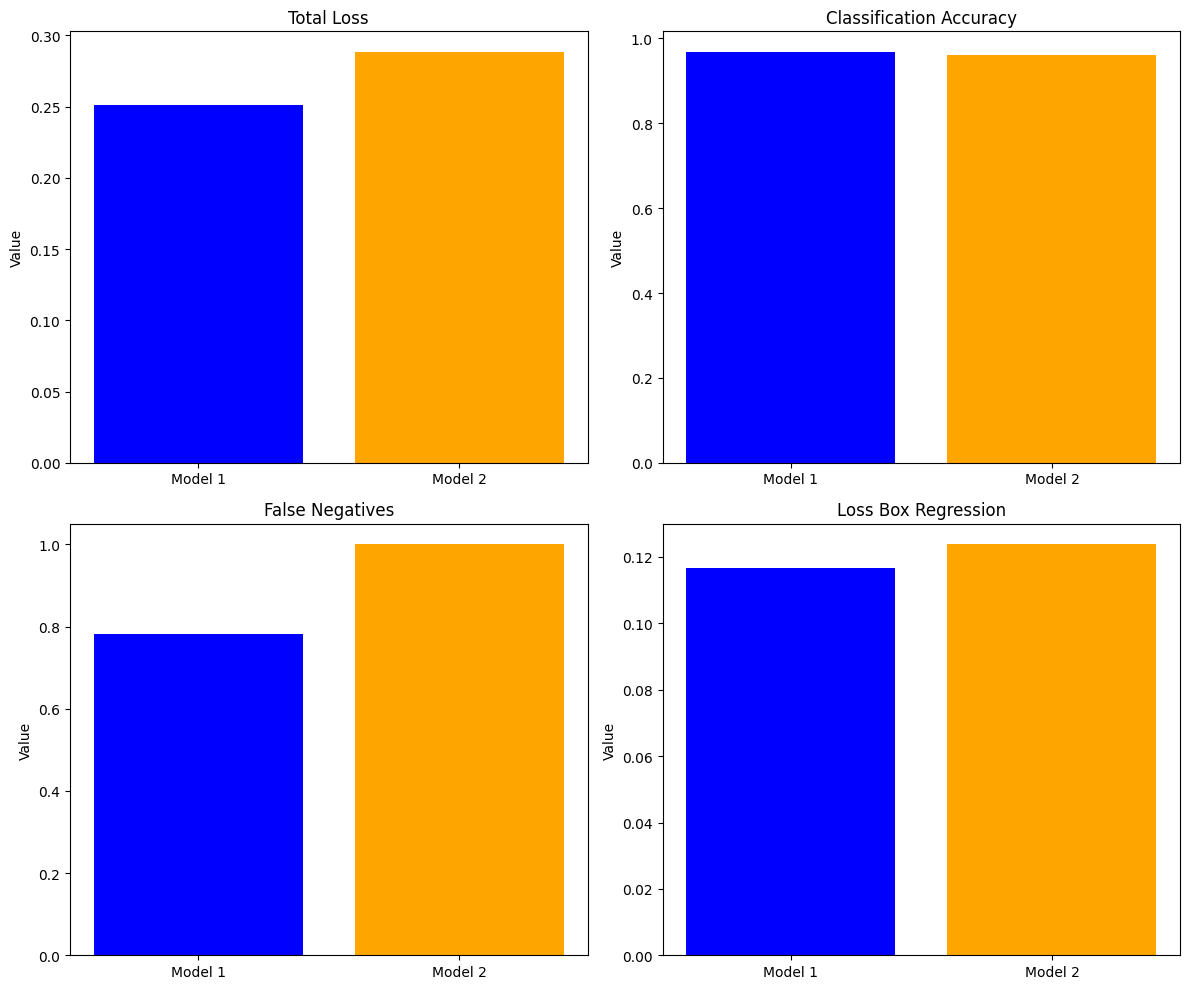

In [ ]:
import matplotlib.pyplot as plt

# Define metric names and values for both models
metrics = ['Total Loss', 'Classification Accuracy', 'False Negatives', 'Loss Box Regression']
model1_values = [total_loss1[-1], cls_acc1[-1], false_neg1[-1], loss_box_reg1[-1]]
model2_values = [total_loss2[-1], cls_acc2[-1], false_neg2[-1], loss_box_reg2[-1]]

# Function to format values to display only the first four digits
def format_values(values):
    return ["{:.4f}".format(value) for value in values]

model1_values_formatted = format_values(model1_values)
model2_values_formatted = format_values(model2_values)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (metric, model1_value, model2_value) in enumerate(zip(metrics, model1_values_formatted, model2_values_formatted)):
    row = i // 2
    col = i % 2
    axs[row, col].bar(['Model 1', 'Model 2'], [float(model1_value), float(model2_value)], color=['blue', 'orange'])
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel('Value')

plt.tight_layout()
plt.show()
